In [1]:
# À décommenter si on veut ajuster l'orientation des figures
#%matplotlib qt

# À commenter si on veut ajuster l'orientation des figures
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import ticker, cm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage.transform import resize

import math

import seaborn as sns; sns.set()
np.random.seed(42)

In [2]:
class genere_distributions():
    nx, ny = 300, 300
    rstride, cstride = 5, 5
    npts = 10000
    
    def __init__(self, mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max):
        self.mu = mu
        self.sigma = sigma
        self.angle = angle
        self.prob_C = prob_C
        self.x_min = x_min 
        self.x_max = x_max 
        self.y_min = y_min 
        self.y_max = y_max 
        
        # Calcul du nombre de points 2D dans chaque nuage de points. 
        self.n = (self.npts*prob_C).astype(int)
                
        # Génération des données 2D à partir des matrices de covariance individuelles (séparées)
        self.genere_dataset()
        
        # Calcule la PDF globale 2D en utilisant les vraies valeurs des paramètres
        self.genere_pdf()
        
        # Estimation des paramètres des PDF gaussiennes à partir de ces données
        self.estime_parametres_dataset()
        
        # Détermination de la zone d'influence de chaque nuage en utilisant deux méthodes de classification: 
        #    I:  Quadratic Discriminant Analysis (Matrice de covariance S partagée)
        #    II: Quadratic Discriminant Analysis (Matrices de covariance S séparées)
        self.genere_classifications()
        

        
    
    # Génère deux nuages de points 2D basés sur les 2 vraies distributions étudiées
    def genere_dataset(self):
        # Calcule les matrices de covariance
        self.calcule_mat_cov()
        
        self.X0 = np.random.multivariate_normal(self.mu[0], self.cov[:,:,0], self.n[0])        
        self.X1 = np.random.multivariate_normal(self.mu[1], self.cov[:,:,1], self.n[1])
        self.X = np.r_[self.X0, self.X1]
        self.y = np.hstack((np.zeros(self.n[0]), np.ones(self.n[1])))

        
    # Génère la distribution globale de probabilités (PDF) en utilisant les vraies valeurs des paramètres
    # La PDF globale est uniquement utilisée pour l'affiche des résultats
    def genere_pdf(self):
        # Calcul des positions (x,y) d'un maillage régulier couvrant le plan xy
        self.genere_grid()
        
        modeles = [None]*2
        
        for i in range(2):
            # Génère modele pour PDF normale 2D
            modeles[i] = multivariate_normal(self.mu[i,:], self.cov[:,:,i]) 

        # Génère PDF individuelles
        pdf0 = modeles[0].pdf(self.pos)
        pdf1 = modeles[1].pdf(self.pos)

        # PDF globale avec pondération
        self.pdf = self.prob_C[0]*pdf0 + self.prob_C[1]*pdf1
        

    # Calcul des positions (x,y) d'un maillage régulier couvrant le plan XY
    def genere_grid(self):
        self.xx, self.yy = np.meshgrid(np.linspace(self.x_min, self.x_max, self.nx), 
                                       np.linspace(self.y_min, self.y_max, self.ny))
        self.pos = np.dstack((self.xx, self.yy))        
        
        

    # Calcul des matrices de covariance basées sur les valeurs des sigma et de l'angle de rotation
    def calcule_mat_cov(self):
        self.cov = np.zeros((2, 2, 2))
        for i in range(2):
            # Matrice de rotation
            theta = np.radians(self.angle[i])
            c, s = np.cos(theta), np.sin(theta)
            R = np.array([[c, -s], [s, c]])
            
            # Matrice de covariance sans rotation
            C = np.array([[self.sigma[i, 0]**2, 0.],[0., self.sigma[i, 1]**2]])

            # Matrice de covariance après rotation
            # new_cov = rotation_matrix @ cov @ rotation_matrix.T
            self.cov[:,:,i] = R.dot(C.dot(R.T) ) 

            
    # Estimation des paramètres des gaussiennes à partir des nuages de points. 
    def estime_parametres_dataset(self):        
        self.mu_hat = np.zeros([2,2])
        self.cov_hat = np.zeros([2,2,2])
        self.prob_C_hat  = np.zeros([2,])

        for i in range(2):
            indx = np.where(self.y==i)
            x = np.squeeze(self.X[indx,:])
            self.mu_hat[i,:] = np.mean(x,axis=0)
            self.cov_hat[:,:,i] = np.cov(x.T)
            self.prob_C_hat[i] = self.prob_C[i]            

    
    # Fonction déterminant de la zone d'influence de chaque nuage en utilisant deux méthodes de classification. 
    def genere_classifications(self):
        
        # Méthode I:  Quadratic Discriminant Analysis (Matrice de covariance S partagée)
        Xgrid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        qda = QuadraticDiscriminantAnalysis(store_covariance=True) 
        Z = qda.fit(self.X, self.y).predict(Xgrid) 
        Z = Z.reshape(self.xx.shape)
        self.masque1 = Z<0.5
        
        
        # Méthode II: Quadratic Discriminant Analysis (Matrices de covariance S séparées)
        Xgrid = Xgrid.T
        
        # Calcul des fonctions discriminantes 
        h = np.zeros((Xgrid.shape[1],2))
        for i in range(2):
            h[:,i] = self.fonction_discriminante(self.mu_hat[i,:], self.cov_hat[:,:,i], self.prob_C_hat[i], Xgrid)        

        # Identifie la zone d'influence de chaque nuage de points en prédisant la classe pour chaque 
        # position (x,y) dans le maillage 2D. La classe gagnante est celle pour laquelle h(x) est maximale.
        Z = np.argmax(h,axis=1)
        Z = Z.reshape(self.xx.shape)
        self.masque2 = Z>0.5
        

        
    # Calcul d'une fonction discriminante
    def fonction_discriminante(self, moy, S, pC, X):
        moy = np.reshape(moy.T, [2,1])
        
        S_inv = np.linalg.inv(S)
        det_S = np.linalg.det(S)
               
        w0 = -0.5*math.log(det_S) + math.log(pC)
        
        ww = np.zeros([X.shape[1]])
        for i in range(X.shape[1]):
            dX = np.reshape(X[:,i], [2,1]) - moy
            ww[i] = (dX.T).dot(S_inv.dot(dX))
        
        h = ww + w0
        
        return h  
                
            
    # Affiche la fonction de distribution globale en 3D avec ses contours en 2D. L'orientation de 
    # la figure peut être ajustée avec la souris; cela affiche la valeur de la variable view = [azimuth, élévation]
    def affiche_PDF_avec_contours(self, contours_remplis=True, affiche_labels=True, affiche_tickmarks=True, 
                                  view=[20., -20.], offset = -0.15, nom_figure=None):
                
        fig = plt.figure(figsize = (20,10))
        fig.canvas.set_window_title('3D')
        
        for i in range(2):
            ax = fig.add_subplot(1, 2, i+1, projection='3d')

            if (i==0):
                # Méthode I:  Quadratic Discriminant Analysis (Matrice de covariance S partagée)
                titre = 'Fonction discriminante quadratique \nMatrice de covariance S partagée'
                masque = self.masque1
            else:
                # Méthode II: Quadratic Discriminant Analysis (Matrices de covariance S séparées)
                titre = 'Fonction discriminante quadratique \nMatrices de covariance S séparées'
                masque = self.masque2              


            # Génération de la surface 3D en 2 couleurs identifiant les zones d'influence de chaque nuage
            self.genere_surf_3D(ax,masque)

            # Contours 2D remplis en dessous
            if (contours_remplis==True):
                cset = ax.contourf(self.xx, self.yy, self.pdf, zdir='z', offset=offset, cmap='viridis')
            else:
                cset = ax.contour(self.xx, self.yy, self.pdf, zdir='z', offset=offset, levels = 10, cmap='hot') 

            # Affiche frontières entre les zones d'influence
            ax.contour(self.xx, self.yy, masque, [0.5], offset=offset, linewidths=2., colors='white') 



            ax.set_zlim(offset,np.max(self.pdf))

            ax.view_init(view[0], view[1])
                      
            ax.set_title(titre, fontsize=20)

            if (affiche_labels==True):
                ax.set_ylabel('$x_{2}$', fontsize=18)
                ax.xaxis.set_rotate_label(False)  
                ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)

            if (affiche_tickmarks==False):
                # Enlève tickmarks
                ax.xaxis.set_major_formatter(NullFormatter())
                ax.yaxis.set_major_formatter(NullFormatter())
                ax.zaxis.set_major_formatter(NullFormatter())
                

            # Affiche la pondération de chaque classe
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.99)
            str1 = '%0.1f' % self.prob_C[0]
            str2 = '%0.1f' % self.prob_C[1]    
            texte = '$P(w_{1}) = ' + str1 +'$' + '\n' + '$\mathbf{P(w_{2}) = ' + str2 + '}$'
            ax.text(0.0, 0.1, 0.1, texte, zdir='y', fontsize=14, bbox=props)

            fig.tight_layout()
        
        
        # Sauvegarde de l'image 
        if nom_figure!=None:
            plt.savefig(nom_figure, format="svg")
        
        
        plt.show()
            
        
        
    # Génération de la surface 3D en 2 couleurs identifiant la zone d'influence de chaque nuage    
    def genere_surf_3D(self, ax, masque):

        s = ax.plot_surface(self.xx, self.yy, self.pdf, rstride=self.rstride, cstride=self.cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')       
        a1 = s.__dict__['_original_facecolor']
        b1 = s.__dict__['_facecolors']
        c1 = s.__dict__['_facecolors3d']
        
        s = ax.plot_surface(self.xx, self.yy, self.pdf, rstride=self.rstride, cstride=self.cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')
        a2 = s.__dict__['_original_facecolor']
        b2 = s.__dict__['_facecolors']
        c2 = s.__dict__['_facecolors3d']
        
        Lx = int(self.nx/self.rstride)
        Ly = int(self.ny/self.cstride)

        mask = resize(masque, (Lx,Ly), order=0)
        indx = np.argwhere(mask)
        idx = indx[:,0]*Lx + indx[:,1]

        a = a1
        b = b1
        c = c1
        for i in idx:
            a[i,:] = a2[i,:]
            b[i,:] = b2[i,:]
            c[i,:] = c2[i,:]
        s.__dict__['_original_facecolor'] = a
        s.__dict__['_facecolors'] = b
        s.__dict__['_facecolors3d'] = c

   


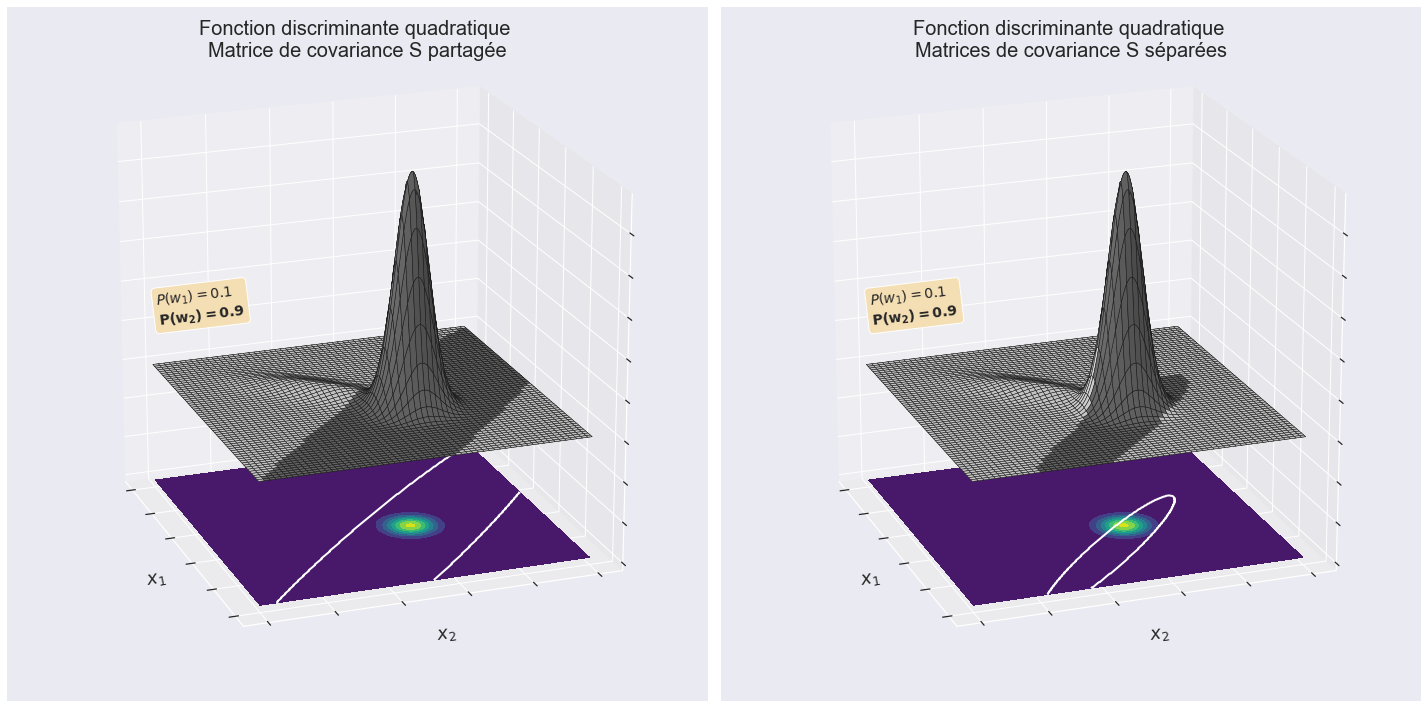

In [3]:
if __name__=='__main__':
        
    # ------- Paramètres des gaussiennes --------
    mu = np.zeros((2,2))
    mu[0,:] = [4., 4.]
    mu[1,:] = [6., 6.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [1.5, .5]
    sigma[1,:] = [0.5, 0.5]

    angle = np.array([45., 0.]) 

    prob_C = np.array([0.1, 0.9]) 
    
    x_min, x_max = 0., 10.
    y_min, y_max = 0., 10.


    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales d'angles de vue (avec la souris) et d'offset  
    # N.B. view = [élévation, azimuth]
    #pdf.affiche_PDF_avec_contours(offset = -0.30)
    
    # Affichage et sauvegarde des meilleurs résultats
    nom_figure = "Figure_28(1)_41.svg"
    pdf.affiche_PDF_avec_contours(offset = -0.30, view=[20, -20], affiche_tickmarks=False, nom_figure=nom_figure)

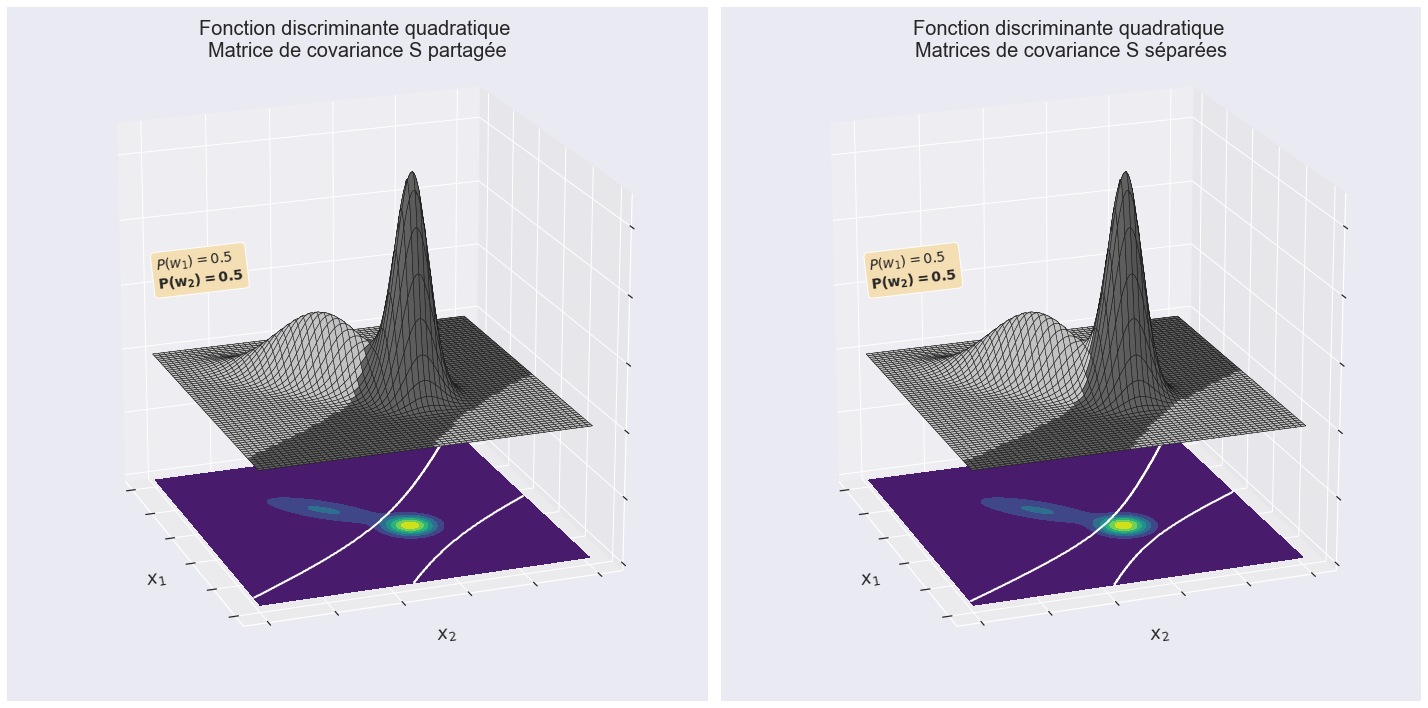

In [4]:
        
    # ------- Paramètres des gaussiennes --------
    mu = np.zeros((2,2))
    mu[0,:] = [4., 4.]
    mu[1,:] = [6., 6.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [1.5, .5]
    sigma[1,:] = [0.5, 0.5]

    angle = np.array([45., 0.]) 

    prob_C = np.array([0.5, 0.5]) 
    
    x_min, x_max = 0., 10.
    y_min, y_max = 0., 10.


    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales d'angles de vue (avec la souris) et d'offset  
    # N.B. view = [élévation, azimuth]  
    #pdf.affiche_PDF_avec_contours(offset = -0.20)
    
    # Affichage et sauvegarde des meilleurs résultats
    nom_figure = "Figure_28(2)_41.svg"
    pdf.affiche_PDF_avec_contours(offset = -0.20, view=[20, -20], affiche_tickmarks=False, nom_figure=nom_figure)
    

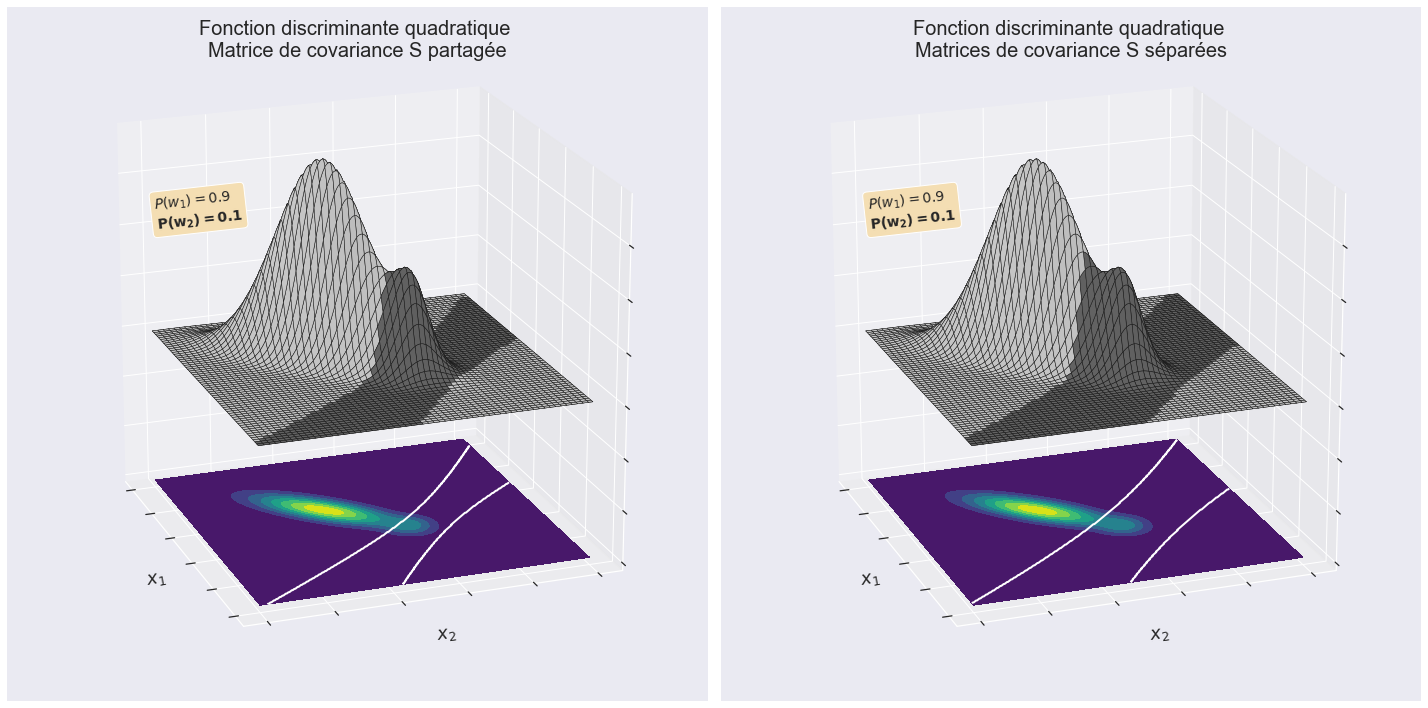

In [5]:
        
    # ------- Paramètres des gaussiennes --------
    mu = np.zeros((2,2))
    mu[0,:] = [4., 4.]
    mu[1,:] = [6., 6.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [1.5, .5]
    sigma[1,:] = [0.5, 0.5]

    angle = np.array([45., 0.]) 

    prob_C = np.array([0.9, 0.1]) 
    
    x_min, x_max = 0., 10.
    y_min, y_max = 0., 10.


    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales d'angles de vue (avec la souris) et d'offset  
    # N.B. view = [élévation, azimuth]
    #pdf.affiche_PDF_avec_contours(offset = -0.15)
    
    # Affichage et sauvegarde des meilleurs résultats
    nom_figure = "Figure_28(3)_41.svg"
    pdf.affiche_PDF_avec_contours(offset = -0.15, view=[20, -20], affiche_tickmarks=False, nom_figure=nom_figure)
    